In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.cluster import KMeans
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
import csv
from sklearn.model_selection import train_test_split

In [2]:
images_path = '/home/navya/Documents/sjsu/project-257/dataset-resized/dataset-resized'

# CARDBOARD = 0 GLASS = 1 METAL = 2 PAPER = 3 PLASTIC = 4 TRASH = 5
types = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

#using SIFT feature descriptor
sift = cv2.xfeatures2d.SIFT_create()

files = []
labels = []
for i, each_type in enumerate(types):
    path = join(images_path, each_type) 
    for f in listdir(path)[:70]:
        file_path = join(path, f)
        if isfile(file_path):
            files.append(file_path)
            labels.append(i)

images = np.empty(len(files), dtype=object)
for i in range(len(files)):
    images[i] = cv2.imread(files[i], 0)
    images[i] = cv2.normalize(images[i], None, 0, 255, cv2.NORM_MINMAX)
    #(kps, descs) = surf.detectAndCompute(images[i], None)

#splitting the datset for training and testing in the ratio 4:1
images_train, images_test, y_train, y_test = train_test_split(images,labels, test_size=0.2, random_state=16)




In [3]:
def to_surf_desc(image):
    (kps, descs) = sift.detectAndCompute(np.array(image), None)
    #print (type(descs))
    #print (descs.shape)
    if descs is None:
        return np.empty((1, 128))
    return descs
    
image_surf_train = [to_surf_desc(image) for image in images_train]
image_surf_test = [to_surf_desc(image) for image in images_test]



In [4]:

def BOVW(feature_descriptors, n_clusters = 128):
    print("Bag of visual words with {} clusters".format(n_clusters))
    #combined_features = np.vstack(np.array(feature_descriptors))
    combined_features = [point for image_keypoints in feature_descriptors for point in image_keypoints]
    print("Starting K-means training")
    kmeans_obj = KMeans(n_clusters=128, random_state=20).fit(combined_features)
    return kmeans_obj

def predict_bow_features(kmeans, descs):
    
    X = []
    for (i, desc) in enumerate(descs):
        if len(desc) == 0:
            continue
        result = kmeans.predict(desc)
        cluster_vector = [(result == i).sum() for i in range(0, kmeans.n_clusters)]
        X.append(cluster_vector)
    return np.array(X)
    

In [5]:

#from collections import Counter

kmeans = BOVW(image_surf_train)
x_train = predict_bow_features(kmeans, image_surf_train)
x_test = predict_bow_features(kmeans, image_surf_test)
#x_train = pca.transform(x_train1)


Bag of visual words with 128 clusters
Starting K-means training


In [6]:

model = svm.SVC(max_iter=10000, C=100, kernel='linear', gamma=0.5, probability=True)
model.fit(x_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='linear',
    max_iter=10000, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [7]:
confidence_of_model = model.predict_proba(x_train)
confidence_example = np.amax(confidence_of_model, axis=1)
print(stats.describe(confidence_example))

DescribeResult(nobs=336, minmax=(0.2054810370482889, 0.8860055984389108), mean=0.3380269295415636, variance=0.011151197091258615, skewness=1.754465405557099, kurtosis=4.172200295990555)


In [8]:
def get_accuracy(y_predict, y):
    accuracy = np.sum(y_predict == y).__float__() / float(len(y))
    confusion_matrix = metrics.confusion_matrix(y_predict, y, labels=[0, 1, 2, 3, 4, 5])
    return (accuracy, confusion_matrix)

In [9]:
 # Testing the SVM model

y_train_predict = np.array(model.predict(x_train))
y_test_predict = np.array(model.predict(x_test))
(train_accuracy, train_confusion_matrix) = get_accuracy(y_train_predict, y_train)
(test_accuracy, test_confusion_matrix) = get_accuracy(y_test_predict, y_test)
print('Train accuracy: ' + str(train_accuracy))
print('Train confusion matrix:')
print(train_confusion_matrix)
print('Test accuracy: ' + str(test_accuracy))
print('Test confusion matrix:')
print(test_confusion_matrix)

Train accuracy: 1.0
Train confusion matrix:
[[60  0  0  0  0  0]
 [ 0 56  0  0  0  0]
 [ 0  0 57  0  0  0]
 [ 0  0  0 55  0  0]
 [ 0  0  0  0 57  0]
 [ 0  0  0  0  0 51]]
Test accuracy: 0.2976190476190476
Test confusion matrix:
[[3 5 3 4 1 2]
 [2 2 1 4 3 1]
 [2 1 5 0 1 2]
 [2 1 2 6 1 4]
 [0 3 1 1 4 5]
 [1 2 1 0 3 5]]


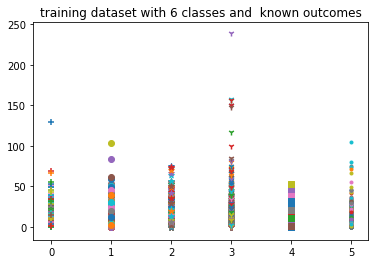

In [37]:
from sklearn.model_selection import cross_val_score
 
#CVSVMModel = crossval(model,'Holdout',0.15)
scores = cross_val_score(model, x_train, y_train, cv=5)
import pylab as pl
#print(pl.imshow.__doc__)
#print(x_train.shape)
markers = ['+', 'o', '*', "1", "s", "."]
for i in range(0, x_train.shape[0]):
    for j in range(len(x_train[i])):
        pl.scatter(y_train[i], x_train[i][j], marker=markers[y_train[i]])
'''
        if y_train[i] == 0:
        c1 = pl.scatter(x_train[i,0],x_train[i,1],c='r',    marker='+')
    elif y_train[i] == 1:
        c2 = pl.scatter(x_train[i,0],x_train[i,1],c='g',    marker='o')
    elif y_train[i] == 2:
        c3 = pl.scatter(x_train[i,0],x_train[i,1],c='b',    marker='*')
    elif y_train[i] == 3:
        c4 = pl.scatter(x_train[i,0],x_train[i,1],c='yellow',    marker="1")
    elif y_train[i] == 4:
        c5 = pl.scatter(x_train[i,0],x_train[i,1],c='black',    marker="o")
    elif y_train[i] == 5:
        c6 = pl.scatter(x_train[i,0],x_train[i,1],c='brown',    marker="s")
'''
#pl.legend(['+', 'o', '*', "1", "s", "."], ['cardboard', 'glass','metal', 'paper', 'plastic', 'trash'])
pl.title('training dataset with 6 classes and  known outcomes')

pl.show()

In [ ]:
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=y)
    plt.title('Dataset after feature extraction & PCA')
    plt.show()

In [11]:
from sklearn.decomposition import PCA
def visualize_features(X, y):
    print('Running PCA on (X, y)...')
    reduced_X = PCA(n_components=2).fit_transform(X)
    print('Displaying dataset on scatterplot...')
    plt.figure(1)
    plt.figure(figsize=(20,10))
    plt.clf()
    plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=y)
    plt.title('Dataset after feature extraction & PCA')
    plt.show()

Running PCA on (X, y)...
Displaying dataset on scatterplot...


<Figure size 432x288 with 0 Axes>

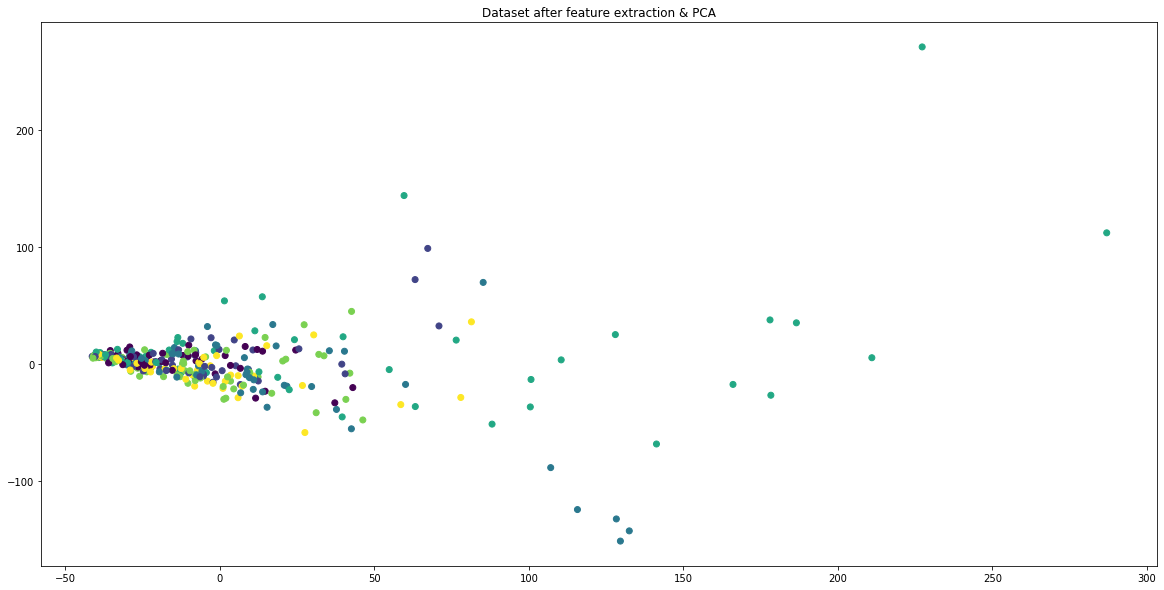

In [12]:
visualize_features(x_train, y_train)